# Fitting transfer function with a ZPK model

In the last tutorial, we tried using generic transfer function model to fit a transfer function

\begin{equation}
    H(s) = \frac{s^2 + 3s + 2}{s^3 + 12s^2 + 47s + 60}\,.
\end{equation}

Although we ended up with a transfer function that fits the data, the parameters were not correct.

If we factorize the the numerator and denominator, in fact, we get

\begin{equation}
    H(s) = \frac{(s+1)(s+2)}{(s+3)(s+4)(s+5)}\,
\end{equation}

which is a more desirable form (The first form has 7 parameters, and the latter one has 6! That means the solution is not unique if we use the first form!).

Let's try to fit the data with ``kontrol.curvefit.model.SimpleZPK`` instead.

``kontrol.curvefit.model.SimpleZPK`` is defined as

\begin{equation}
    G(s; z_i, p_j, k) = k\frac{\prod_i s/z_i + 1}{\prod_j s/p_j + 1}\,.
\end{equation}

So the parameters we are looking for are [1, 2, 3, 4, 5, 1]. But we typically work in unit of Hz instead of rad/s.

So, the true parameters are **[0.15915494, 0.31830989, 0.47746483, 0.63661977, 0.79577472, 0.03333333]**.
Note that for the first two parameters (zeros), the order doesn't matter, and same goes for

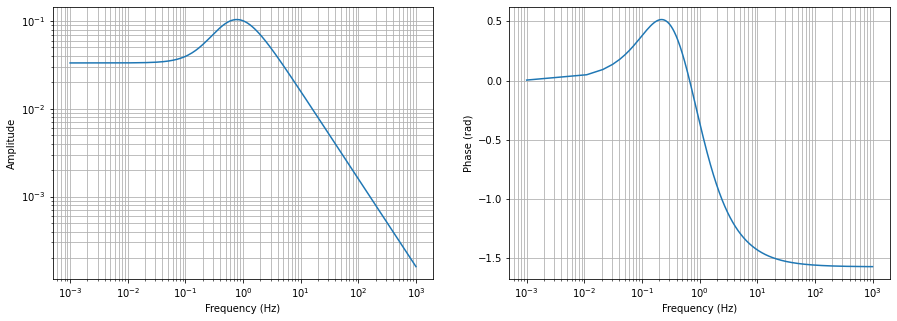

In [1]:
# Same as the previous tutorial
import control
import numpy as np
import matplotlib.pyplot as plt

f = np.linspace(0.001, 1000, 100000)
s = 1j*2*np.pi*f
tf = (s**2 + 3*s + 2) / (s**3 + 12*s**2 + 47*s + 60)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.loglog(f, abs(tf))
plt.grid(which="both")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.subplot(122)
plt.semilogx(f, np.angle(tf))
plt.grid(which="both")
plt.ylabel("Phase (rad)")
plt.xlabel("Frequency (Hz)")
plt.show()

In [2]:
import kontrol.curvefit
import scipy.optimize

a = kontrol.curvefit.CurveFit()
a.xdata = f
a.ydata = tf
a.model = kontrol.curvefit.model.SimpleZPK(nzero=2, npole=3, log_args=False)
error_func = kontrol.curvefit.error_func.tf_error
weight = 1/f
error_func_kwargs = {"weight": weight}
a.cost = kontrol.curvefit.Cost(error_func=error_func, error_func_kwargs=error_func_kwargs)
a.optimizer = scipy.optimize.minimize
np.random.seed(123)
true_args = np.array([0.15915494, 0.31830989, 0.47746483, 0.63661977, 0.79577472, 0.03333333])  # These are the true parameters
noise = np.random.normal(loc=0, scale=true_args/10, size=6)
x0 = true_args + noise  # Now the initial guess is assumed to be some deviation from the true values.

a.optimizer_kwargs = {"x0": x0,}

res = a.fit()

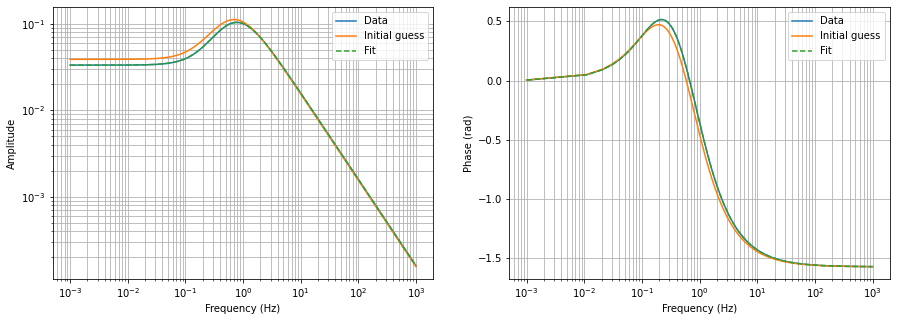

In [3]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.loglog(f, abs(tf), label="Data")
plt.loglog(f, abs(a.model(f, x0)), label="Initial guess")
plt.loglog(f, abs(a.yfit), ls="--", label="Fit")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.subplot(122)
plt.semilogx(f, np.angle(tf), label="Data")
plt.semilogx(f, np.angle(a.model(f, x0)), label="Initial guess")
plt.semilogx(f, np.angle(a.yfit), ls="--", label="Fit")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Phase (rad)")
plt.xlabel("Frequency (Hz)")
plt.show()

In [4]:
print("True parameters :", true_args)
print("Parameters from fit: ", a.optimized_args)

True parameters : [0.15915494 0.31830989 0.47746483 0.63661977 0.79577472 0.03333333]
Parameters from fit:  [0.15889944 0.32540938 0.54057908 0.55856226 0.81765228 0.03333333]


Let's convert it into transfer function and obtain the transfer function representation.

In [5]:
print("True transfer function")
s = control.tf("s")
tf_ = (s**2 + 3*s + 2) / (s**3 + 12*s**2 + 47*s + 60)
tf_

True transfer function


TransferFunction(array([1, 3, 2]), array([ 1, 12, 47, 60]))

In [6]:
print("Fitted transfer function")
a.model.args = a.optimized_args
a.model.tf.minreal()

Fitted transfer function


TransferFunction(array([1.00001277, 3.04304098, 2.04135122]), array([ 1.        , 12.04356952, 47.40025543, 61.24054977]))

Much better!

Now, with the ZPK model, we don't really have to use local minimization. We know the the location of poles and zeros are within the measured frequency band so we can put a bound on the model parameters. This means that we don't even need an initial guess.

In [11]:
bounds = [(0.1, 1)] * 5  # Say we know the features are between 0.01 and 10 Hz.
bounds += [(abs(tf[0])/10, (abs(tf[0])*10))]  # around the lower frequency value
a.optimizer = scipy.optimize.differential_evolution
a.optimizer_kwargs = {"bounds": bounds, "workers": -1, "updating": "deferred"}
np.random.seed(123)  # Fix random seed for reproducibility
a.fit()


     fun: -0.11893392985453001
 message: 'Optimization terminated successfully.'
    nfev: 14480
     nit: 156
 success: True
       x: array([0.24229786, 0.17012243, 0.7466101 , 0.74350342, 0.35457821,
       0.03333341])

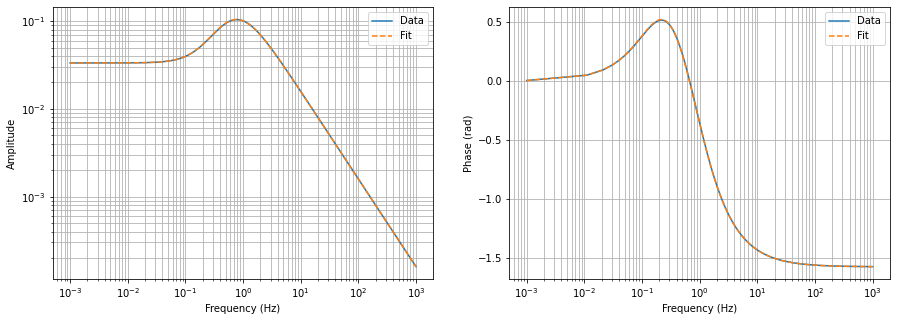

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.loglog(f, abs(tf), label="Data")
# plt.loglog(f, abs(a.model(f, x0)), label="Initial guess")
plt.loglog(f, abs(a.yfit), ls="--", label="Fit")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.subplot(122)
plt.semilogx(f, np.angle(tf), label="Data")
# plt.semilogx(f, np.angle(a.model(f, x0)), label="Initial guess")
plt.semilogx(f, np.angle(a.yfit), ls="--", label="Fit")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Phase (rad)")
plt.xlabel("Frequency (Hz)")
plt.show()

In [13]:
print("Fitted transfer function")
a.model.args = a.optimized_args
a.model.tf.minreal()

Fitted transfer function


TransferFunction(array([1.00008588, 2.59153569, 1.62745205]), array([ 1.        , 11.59053998, 42.77363963, 48.82345181]))